# Image manipulation detection and localization pipeline

## Imports and preperations

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.patches as patches

In [ ]:
DATA_ROOT_PATH = './Data/CASIA2'
SAVE_PATH = 'ForgeryDetectionModelEfficientNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Targeting device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Allocated Memory: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
else:
    print("Warning: CUDA not found. Training will be slow on CPU!")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Load and prepare Data

In [ ]:
def perform_ela(image_path, quality=90):
    original = Image.open(image_path).convert('RGB')

    resave_path = 'temp_resaved.jpg'
    original.save(resave_path, 'JPEG', quality=quality)
    resaved = Image.open(resave_path)

    ela_image = ImageChops.difference(original, resaved)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
class Casia2Dataset(Dataset):
    def __init__(self, root_dir, transform=None, task='binary'):
        self.root_dir = root_dir
        self.transform = transform
        self.task = task
        self.image_paths = []
        self.labels = []

        au_path = os.path.join(root_dir, 'Au')
        tp_path = os.path.join(root_dir, 'Tp')

        print(f"Loading images from {au_path}...")
        print(f"Loading images from {tp_path}...")

        if task == 'binary':
          for img in os.listdir(au_path):
            if img.lower().endswith(('.jpg', '.tif')):
              self.image_paths.append(os.path.join(au_path, img))
              self.labels.append(0)

        for img in os.listdir(tp_path):
          if img.lower().endswith(('.jpg', '.tif')):
            if task == 'binary':
              self.image_paths.append(os.path.join(tp_path, img))
              self.labels.append(1)
            elif task == 'type':
              parts = img.split('_')

              is_spliced = parts[5] != parts[6]
              is_copymove = parts[5] == parts[6]

              if is_spliced:
                self.image_paths.append(os.path.join(tp_path, img))
                self.labels.append(0) # Spliced
              elif is_copymove:
                self.image_paths.append(os.path.join(tp_path, img))
                self.labels.append(1) # Copy-Move


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = perform_ela(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

## Trainingfunction

In [ ]:
def train_loop(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=5):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        epoch_acc = correct_train / total_train
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val

        val_epoch_loss = running_val_loss / len(val_loader.dataset)
        val_epoch_acc = correct_val / total_val
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            checkpoint_file = os.path.join(SAVE_PATH, 'best_forgery_model.pth')
            torch.save(model.state_dict(), checkpoint_file)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered! No improvement for {patience} epochs.")
                break

    model.load_state_dict(best_model_wts)
    print(f"Training Complete. Best Val Acc: {best_acc:.2f}%")
    return model, history

## Training of pre-trained EfficientNet

In [ ]:
def train_pretrained_efficientnet_b0(train_loader, val_loader, device):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    num_ftrs = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 2)
    )

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    trained_model, history = train_loop(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=5)

    return trained_model, history

In [ ]:
full_dataset = Casia2Dataset(root_dir=DATA_ROOT_PATH, transform=transform, task='binary')

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
bin_model_pretrained, history = train_pretrained_efficientnet_b0(train_loader, val_loader, device)

torch.save(bin_model_pretrained.state_dict(), os.path.join(SAVE_PATH, 'model_binary_pretrained_02.pth'))

In [ ]:
full_dataset_type = Casia2Dataset(root_dir=DATA_ROOT_PATH, transform=transform, task='type')

train_size_type = int(0.8 * len(full_dataset_type))
val_size_type = len(full_dataset_type) - train_size_type
train_dataset_type, val_dataset_type = random_split(full_dataset_type, [train_size_type, val_size_type])

train_loader_type = DataLoader(train_dataset_type, batch_size=32, shuffle=True)
val_loader_type = DataLoader(val_dataset_type, batch_size=32, shuffle=False)

In [ ]:
type_model_pretrained, history_type = train_pretrained_efficientnet_b0(train_loader_type, val_loader_type, device)

torch.save(type_model_pretrained.state_dict(), os.path.join(SAVE_PATH, 'model_type_pretrained_02.pth'))

## Localization using U-Net

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final_conv(d1))

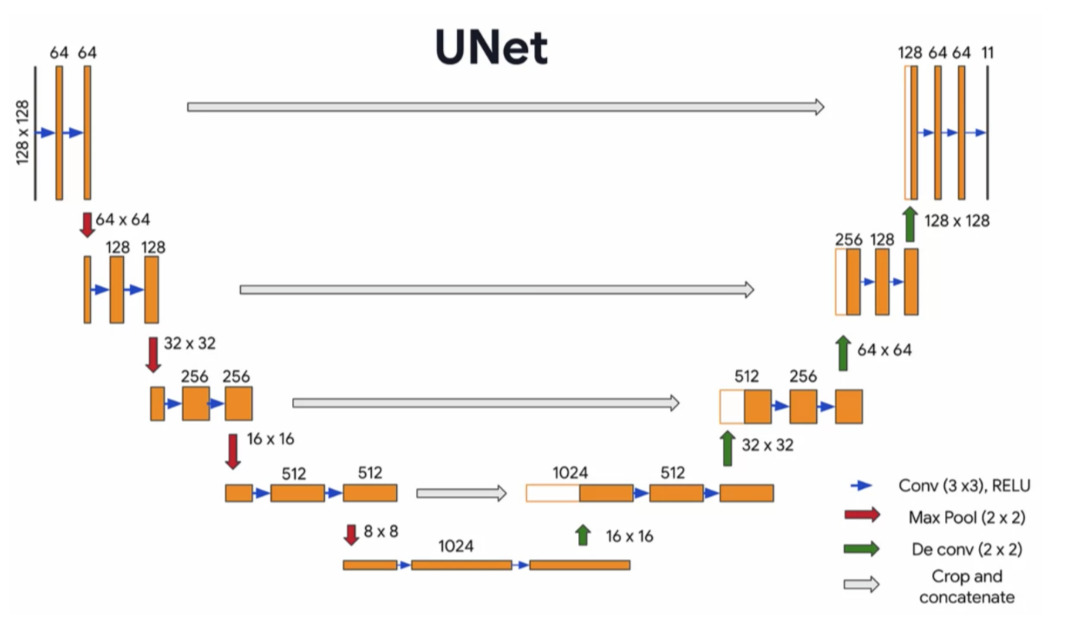

In [ ]:
localization_model = UNet().to(device)

In [ ]:
class Casia2LocalizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.mask_dir = os.path.join(root_dir, 'CASIA 2 Groundtruth')
        self.tp_dir = os.path.join(root_dir, 'Tp')
        self.transform = transform

        self.image_paths = []
        for f in os.listdir(self.tp_dir):
            if f.lower().endswith(('.jpg', '.tif')):
                self.image_paths.append(os.path.join(self.tp_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path)
        name_part, _ = os.path.splitext(filename)

        mask_filename = f"{name_part}_gt.png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        if not os.path.exists(mask_path):
            return None, None

        ela_image = perform_ela(img_path)
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            ela_image = self.transform(ela_image)
            mask_transform = transforms.Compose([
                transforms.Resize(ela_image.shape[1:]),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)

        return ela_image, mask

In [ ]:
def collate_skip_empty(batch):
    batch = [sample for sample in batch if sample[0] is not None]
    if len(batch) == 0:
        return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
full_dataset_localization = Casia2LocalizationDataset(DATA_ROOT_PATH, transform=transform)

train_size_loc = int(0.8 * len(full_dataset_localization))
val_size_loc = len(full_dataset_localization) - train_size_loc
train_dataset_loc, val_dataset_loc = random_split(full_dataset_localization, [train_size_loc, val_size_loc])

train_loader_loc = DataLoader(
    train_dataset_loc,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_skip_empty
)
val_loader_loc = DataLoader(
    val_dataset_loc,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_skip_empty
)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(localization_model.parameters(), lr=1e-4)

train_loop(localization_model, train_loader_loc, val_loader_loc, criterion, optimizer, device)

torch.save(localization_model.state_dict(), os.path.join(SAVE_PATH, 'model_localization_unet_02.pth'))

## Loading the models

In [ ]:
def load_forgery_model(model_path, device):
    model = models.efficientnet_b0(weights=None)
    num_ftrs = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 2)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [ ]:
saved_bin_pretrained_model = load_forgery_model(os.path.join(SAVE_PATH, 'model_binary_pretrained_02.pth'), device)

In [ ]:
saved_type_pretrained_model = load_forgery_model(os.path.join(SAVE_PATH, 'model_type_pretrained_02.pth'), device)

## Confusion Matrix

In [ ]:
def create_confusion_matrix(model, dataloader):
  all_preds = []
  all_labels = []

  model.eval()
  with torch.no_grad():
      for inputs, labels in dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_preds)
  return cm

In [ ]:
conf_matrix = create_confusion_matrix(saved_bin_pretrained_model, train_loader)
print(conf_matrix)

In [ ]:
conf_matrix_val = create_confusion_matrix(saved_bin_pretrained_model, val_loader)
print(conf_matrix_val)

In [ ]:
def visualize_conf_matrix(class_names, conf_matrix, name):
  conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

  plt.figure(figsize=(8,8))
  ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          count = conf_matrix[i, j]
          ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")

  plt.savefig(os.path.join(SAVE_PATH, name), dpi=300)

  plt.show()

In [ ]:
visualize_conf_matrix(["Authentic", "Forged"], conf_matrix, "confusion_matrix_binary_training_01.png")

In [ ]:
visualize_conf_matrix(["Authentic", "Forged"], conf_matrix_val, "confusion_matrix_binary_validation_01.png")

## Accuracy and Loss Graphs

In [ ]:
def visualize_acc_loss(history, name_acc, name_loss):
    plt.plot(history['train_acc'], label='accuracy')
    plt.plot(history['val_acc'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(os.path.join(SAVE_PATH, name_acc), dpi=300)

    plt.show()

    plt.plot(history['train_loss'], label='loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(os.path.join(SAVE_PATH, name_loss), dpi=300)

    plt.show()


In [ ]:
visualize_acc_loss(history, 'Accuracy_Plot_BinModel.png', 'Loss_Plot_BinModel.png')

In [ ]:
visualize_acc_loss(history_type, 'Accuracy_Plot_TypeModel.png', 'Loss_Type_BinModel.png')

## Generation of Heatmap

In [ ]:
def generate_forgery_heatmap(model, img_path, original_class):
    img_ela = perform_ela(img_path, quality=90)
    input_tensor = transform(img_ela).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1).item()
        confidence = probs[0][prediction].item()

    original_img = Image.open(img_path).convert('RGB').resize((224, 224))
    original_img_np = np.array(original_img).astype(np.float32) / 255

    ela_img_np = np.array(img_ela.resize((224, 224))).astype(np.float32) / 255
    ela_vis_brightened = np.clip(ela_img_np * 15.0, 0, 1)

    target_layers = [model.features[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(prediction)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    heatmap_on_original = show_cam_on_image(original_img_np, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(18, 6))
    class_names = ['Authentic', 'Forged']

    plt.subplot(1, 3, 1)
    plt.title(f"Original {class_names[original_class]}")
    plt.imshow(original_img_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("ELA")
    plt.imshow(ela_vis_brightened)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Heatmap (Pred: {class_names[prediction]} {confidence:.2%})")
    plt.imshow(heatmap_on_original)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRD_S_N_ani00075_art00012_00195.tif'), 1)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRD_S_N_ani00028_ani00058_00148.tif'), 1)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_M_N_ani00097_ani00001_10099.tif'), 1)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Tp/Tp_S_NNN_S_B_arc00094_arc00094_01043.tif'), 1)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_00011.jpg'), 0)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Au/Au_art_30303.jpg'), 0)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Au/Au_cha_30157.jpg'), 0)

In [ ]:
generate_forgery_heatmap(saved_bin_pretrained_model, os.path.join(DATA_ROOT_PATH, 'Au/Au_pla_10120.jpg'), 0)

## Prediction

### Classification

In [ ]:
def predict_image_forgery(path, bin_model, type_model, transform=None):

    ela_img = perform_ela(path)

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    input_tensor = transform(ela_img).unsqueeze(0).to(device)

    bin_model.eval()
    with torch.no_grad():
        bin_output = bin_model(input_tensor)
        probs = torch.softmax(bin_output, dim=1)
        bin_pred = torch.argmax(bin_output, dim=1)
        bin_confidence = probs[0][bin_pred].item()

    if bin_pred.item() == 0:
        label = f"Prediction: Authentic {bin_confidence:.2%}"
        show_result(path, label)
        return
    else:
        label = f"Prediction: Forged {bin_confidence:.2%}"
        show_result(path, label)
        #return

    # Predict type

    type_model.eval()
    with torch.no_grad():
        type_output = type_model(input_tensor)
        _, type_pred = torch.max(type_output, 1)

    type_str = "Splicing" if type_pred.item() == 0 else "Copy-Move"
    label = f"Prediction: Forged; Type: {type_str}"

    show_result(path, label)

def show_result(path, label):
    img = Image.open(path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()


#### True label Authentic

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_00033.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_00004.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_00087.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_10142.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_10209.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_ani_20049.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_arc_00029.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_arc_00080.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_arc_20052.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Au/Au_sec_30273.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

#### True label Forged

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRD_S_N_ani00028_ani00058_00148.tif'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CND_S_N_ani00073_ani00068_00193.tif'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CNN_S_N_cha10122_nat00059_12169.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_M_N_ani00097_ani00001_10099.tif'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_M_N_cha00094_cha00086_11501.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_M_N_nat10156_ani00001_12021.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_S_B_cha00085_ani00064_00405.tif'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_S_N_art00027_art00013_00695.tif'), saved_bin_pretrained_model, saved_type_pretrained_model)

In [ ]:
predict_image_forgery(os.path.join(DATA_ROOT_PATH, 'Tp/Tp_D_CRN_S_N_nat10145_ani00037_11983.jpg'), saved_bin_pretrained_model, saved_type_pretrained_model)

### Localization

In [ ]:
def load_localization_model(save_path, device):
    saved_model = UNet(in_channels=3, out_channels=1).to(device)

    state_dict = torch.load(save_path, map_location=device)
    saved_model.load_state_dict(state_dict)

    saved_model.eval()
    return saved_model

In [ ]:
def calculate_iou(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interWidth = max(0, xB - xA + 1)
    interHeight = max(0, yB - yA + 1)
    interArea = interWidth * interHeight

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [ ]:
def get_box_from_mask(mask_path, target_size=None):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return [0, 0, 0, 0]

    if target_size:
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    _, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return [0, 0, 0, 0]

    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return [x, y, x + w, y + h]

In [ ]:
def predict_and_show_bboxes(image_path, mask_path, model, device, transform, threshold=0.55):
    original_img = Image.open(image_path).convert('RGB')
    orig_w, orig_h = original_img.size

    gt_box = get_box_from_mask(mask_path, target_size=(orig_w, orig_h))

    ela_img = perform_ela(image_path)
    input_tensor = transform(ela_img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).squeeze().cpu().numpy()

    probs_resized = cv2.resize(probs, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)
    binary_mask = (probs_resized > threshold).astype(np.uint8) * 255

    kernel = np.ones((5,5), np.uint8)
    clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(ela_img)
    plt.title("ELA Signal")
    plt.axis('off')

    ax = plt.subplot(1, 2, 2)
    ax.imshow(original_img)

    gx1, gy1, gx2, gy2 = gt_box
    if sum(gt_box) > 0:
        gt_rect = patches.Rectangle((gx1, gy1), gx2-gx1, gy2-gy1, linewidth=3,
                                    edgecolor='#00FF00', facecolor='none', linestyle='--')
        ax.add_patch(gt_rect)
        ax.text(gx1, gy2 + 10, 'GROUND TRUTH', color='#00FF00', weight='bold', fontsize=12)

    for cnt in contours:
        if cv2.contourArea(cnt) > (orig_w * orig_h * 0.001):
            x, y, rw, rh = cv2.boundingRect(cnt)
            pred_box = [x, y, x + rw, y + rh]
            score = calculate_iou(pred_box, gt_box)

            if score > 0.0:
                rect = patches.Rectangle((x, y), rw, rh, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y - 10, f'PRED IoU: {score:.2f}', color='white', weight='bold',
                         bbox=dict(facecolor='red', alpha=0.6, edgecolor='none'))

    plt.title(f"Localization Results (Threshold: {threshold})")
    plt.axis('off')
    plt.show()

In [ ]:
MODEL_PATH = os.path.join(SAVE_PATH, 'model_localization_unet_02.pth')
loc_model = load_localization_model(MODEL_PATH, device)

In [ ]:
test_img = os.path.join(DATA_ROOT_PATH, "Tp/Tp_D_CNN_M_N_sec10107_sec10101_10299.tif")
mask_img = os.path.join(DATA_ROOT_PATH, "CASIA2Groundtruth/Tp_D_CNN_M_N_sec10107_sec10101_10299_gt.png")

predict_and_show_bboxes(test_img, mask_img, loc_model, device, transform)

In [ ]:
test_img = os.path.join(DATA_ROOT_PATH, "Tp/Tp_D_CNN_S_N_art00096_cha00063_10305.tif")
mask_img = os.path.join(DATA_ROOT_PATH, "CASIA2Groundtruth/Tp_D_CNN_S_N_art00096_cha00063_10305_gt.png")

predict_and_show_bboxes(test_img, mask_img, loc_model, device, transform)

In [ ]:
test_img = os.path.join(DATA_ROOT_PATH, "Tp/Tp_D_CRD_S_N_ani00028_ani00058_00148.tif")
mask_img = os.path.join(DATA_ROOT_PATH, "CASIA2Groundtruth/Tp_D_CRD_S_N_ani00028_ani00058_00148_gt.png")

predict_and_show_bboxes(test_img, mask_img, loc_model, device, transform)

In [ ]:
test_img = os.path.join(DATA_ROOT_PATH, "Tp/Tp_D_CRN_M_N_ani00097_ani00001_10099.tif")
mask_img = os.path.join(DATA_ROOT_PATH, "CASIA2Groundtruth/Tp_D_CRN_M_N_ani00097_ani00001_10099_gt.png")

predict_and_show_bboxes(test_img, mask_img, loc_model, device, transform)


In [ ]:
test_img = os.path.join(DATA_ROOT_PATH, "Tp/Tp_D_CRN_S_N_art00027_art00013_00695.tif")
mask_img = os.path.join(DATA_ROOT_PATH, "CASIA2Groundtruth/Tp_D_CRN_S_N_art00027_art00013_00695_gt.png")

predict_and_show_bboxes(test_img, mask_img, loc_model, device, transform)